Found 1840 adjacency matrix files.
Species with >=1000 PubMed publications and evolution data: 114
Filtered to 114 adjacency matrix files with evolution data and >=1000 PubMed publications.
Pearson correlation: 0.4713


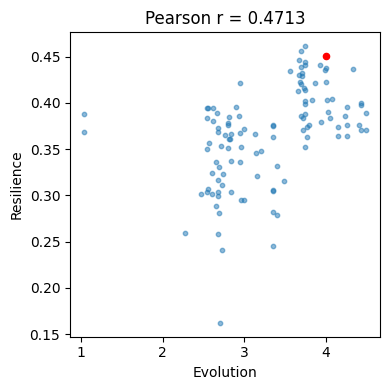

In [5]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import random
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import time
def connected_component_sizes(adj: np.ndarray):
    G = nx.from_numpy_array(adj)
    sizes = [len(c) for c in nx.connected_components(G)]
    assert sum(sizes) == adj.shape[0], f"Sum of component sizes must equal number of nodes: {sum(sizes)} != {adj.shape[0]}"
    return sizes

def compute_shannon_diversity(sizes):
    if len(sizes) == 1:
        return 0.0
    sizes = np.array(sizes)
    total = sizes.sum()
    if total == len(sizes):
        return 1.0
    probs = sizes / total
    shannon_div = -np.sum(probs * np.log(probs + 1e-10)) / np.log(total)
    return shannon_div.item()

random.seed(42)
np.random.seed(42)
data_dir = '../data/treeoflife.interactomes.max_cc_adj'
adj_file_list = [f for f in os.listdir(data_dir) if f.endswith('.npz')]
print(f"Found {len(adj_file_list)} adjacency matrix files.")
df_evolution = pd.read_csv('../data/treeoflife.species.evolution.tsv', sep='\t')
species2evolution = dict(zip(df_evolution['Species_ID'].astype(str), df_evolution['Evolution']))
df_pubmed = pd.read_csv('../data/treeoflife.species.pubmed.count.tsv', sep='\t', comment='#')
df_pubmed_ge1000 = df_pubmed[df_pubmed['Publication_count'] >= 1000]
species_pubmed_ge1000 = df_pubmed_ge1000['Species_ID'].tolist()
df_evolution = df_evolution[df_evolution['Species_ID'].isin(species_pubmed_ge1000)]
# print(f"Filtered to {len(df_evolution)} species with >=1000 PubMed publications.")
species_pubmed_ge1000_evolution = df_evolution['Species_ID'].astype(str).tolist()
print(f"Species with >=1000 PubMed publications and evolution data: {len(species_pubmed_ge1000_evolution)}")
adj_file_list = [f for f in adj_file_list if f.split('.')[0] in species_pubmed_ge1000_evolution]
print(f"Filtered to {len(adj_file_list)} adjacency matrix files with evolution data and >=1000 PubMed publications.")

log_dir = '../logs/resilience_42/'
resilience_list = []
evolution_list = []
homo_sapiens_resilience = None
homo_sapiens_evolution = None
for species in species_pubmed_ge1000_evolution:
    div_list = np.load(os.path.join(log_dir, f'resilience__{species}', 'shannon_diversity.npy'))
    resilience = div_list.max() - div_list.mean()
    resilience_list.append(resilience)
    evolution = species2evolution[species]
    evolution_list.append(evolution)
    if species == '9606':
        homo_sapiens_resilience = resilience
        homo_sapiens_evolution = evolution
resilience_list = np.array(resilience_list)
evolution_list = np.array(evolution_list)
correlation = np.corrcoef(resilience_list, evolution_list)[0, 1]
print(f'Pearson correlation: {correlation:.4f}')

fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=100)
ax.scatter(evolution_list, resilience_list, s=10, alpha=0.5)
# additionally plot homo sapiens as red
if homo_sapiens_evolution is not None and homo_sapiens_resilience is not None:
    ax.scatter(homo_sapiens_evolution, homo_sapiens_resilience, s=20, color='red', label='Homo sapiens')
ax.set_xlabel('Evolution')
ax.set_ylabel('Resilience')
ax.set_title(f'Pearson r = {correlation:.4f}')
plt.tight_layout()

